# Composite maps

In this notebook we analyze composite maps computend on the PlaSim dataset

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


import xarray as xr
import scipy.special as ss
import scipy.stats as stats

import sys
sys.path.append('../../../Climate-Learning/')

import general_purpose.utilities as ut
import general_purpose.cartopy_plots as cplt
import general_purpose.uplotlib as uplt
import general_purpose.tables as tbl

# log to stdout
import logging
logging.getLogger().level = logging.INFO
logging.getLogger().handlers = [logging.StreamHandler(sys.stdout)]
ut.indentation_sep = '  '

HOME = '../../'

In [6]:
def l2(x, **kwargs):
    return np.sqrt(np.sum(x**2, **kwargs))

def xr_l2(da, dim):
    if not isinstance(dim, list):
        dim = [dim]
    return xr.apply_ufunc(lambda x: l2(x).item(), da, input_core_dims=[dim], exclude_dims=set(dim), vectorize=True)

def eta(x):
    return np.sqrt(2/np.pi)*np.exp(-x**2)/ss.erfc(x)

In [7]:
lon = np.load('../../lon.npy')
lat = np.load('../../lat.npy')
LON, LAT = np.meshgrid(lon, lat)

mask = np.load('../mask.npy')
reshaper = ut.Reshaper(mask)
mask.shape, reshaper.surviving_coords

((22, 128, 3), 5644)

In [ ]:
## area weights

coslat = np.cos(lat*np.pi/180)
aw = (np.ones(mask.shape).T * coslat).T
aw *= mask
aw /= np.sum(aw)
aw.shape

## Figure 3

In [ ]:
ds = xr.open_dataset('composite_maps_T14_tau0_y8000.nc')
ds

In [ ]:
emp = ds['empirical_composite'].data.squeeze()
emp.shape

In [ ]:
cnorm = l2(emp*np.sqrt(reshaper.reshape(aw)), axis=1) # total norm
fnorm = l2(reshaper.inv_reshape(emp)*aw, axis=(1,2)) # field-wise norm

In [ ]:
def percent2a(p):
    return np.interp(p, ds['percent'].data.squeeze()[::-1], ds['a'].data[::-1])

In [ ]:
ref_i = 0

plt.close(3)
fig,ax = plt.subplots(num=3, figsize=(9,6))

thrs = ds['a'].data
sigma_A = np.sqrt(ds['Sigma_AA']).data.squeeze()


plt.plot(thrs, cnorm/cnorm[ref_i], color='gray', label='total')

labels = [r'$T_\mathrm{2m}$', r'$Z_\mathrm{500}$', '$S$']
for f in range(fnorm.shape[-1]):
    plt.plot(thrs, fnorm[:,f]/fnorm[ref_i,f],label=labels[f])
    
plt.plot(thrs, eta(thrs/(sigma_A*np.sqrt(2)))/eta(thrs[ref_i]/(sigma_A*np.sqrt(2))), color='black', linestyle='dashed', label=r'$\eta\left(a/\sqrt{2\Sigma_{AA}}\right)/\eta(0)$')

    
plt.legend()

plt.xlabel('$a$ [K]')
plt.ylabel(r'$|C_\mathcal{D}(a)|/|C_\mathcal{D}(0)|$')

ax2 = ax.secondary_xaxis('top')
pticks = np.array([50,20,5,1,0.3,0.1, 0.04])
ax2.set_xticks(percent2a(pticks))
ax2.set_xticklabels(pticks)
ax2.set_xlabel(r'$p$ [%]')

fig.tight_layout()

# fig.savefig(f'{HOME}/scaling.pdf')

## Figure 4

### Load data

In [ ]:
ds = xr.open_dataset('composite_maps_T14_tau0_y8000.nc')
ds

In [ ]:
dsc = xr.open_dataset('composite_maps_T14_tau0_y200-1000.nc')
dsc

In [ ]:
# truth as the empirical composite on the 8000 year dataset
truth = ds['empirical_composite'].sel(years=8000,drop=True)
truth

In [ ]:
# empirical composites
emp = dsc['empirical_composite']
emp

In [ ]:
# gaussian composite
rescale_factor = eta((dsc['a'] - dsc['A_mean'])/np.sqrt(2*dsc['Sigma_AA']))/np.sqrt(dsc['Sigma_AA'])

ga = dsc['Sigma_XA']*rescale_factor + dsc['X_mean']
ga

In [ ]:
area_weights = xr.DataArray(reshaper.reshape(aw), coords={'pixel': np.arange(reshaper.surviving_coords)})
area_weights

### Compute norms

In [ ]:
truth_norm = xr_l2(truth*np.sqrt(area_weights), 'pixel')
truth_norm

In [ ]:
emp_norm = uplt.xr_avg(xr_l2((emp - truth)*np.sqrt(area_weights), 'pixel'), 'fold')
emp_norm

In [ ]:
ga_norm = uplt.xr_avg(xr_l2((ga - truth)*np.sqrt(area_weights), 'pixel'), 'fold')
ga_norm

### Plot

In [ ]:
def percent2a(p):
    return np.interp(p, ds['percent'].data.squeeze()[::-1], ds['a'].data[::-1])

In [ ]:
thresholds = ds['a'].data.squeeze()
emp_nr = emp_norm / truth_norm
ga_nr = ga_norm / truth_norm

plt.close(4)
fig,ax = plt.subplots(num=4, figsize=(9,6))

for i,y in enumerate(ga_norm['years'].data):
    uplt.plot(thresholds + 0.01*i, emp_nr.sel(years=y).data.squeeze(), label=y, color=default_colors[i])
    uplt.errorband(thresholds, ga_nr.sel(years=y).data.squeeze(), color=default_colors[i], linestyle='dashed')
    
# plt.axhline(0, color='gray', linestyle='dashed')
plt.legend(title='Dataset years')
plt.xlabel('$a$ [K]')
# plt.ylabel("$\mathcal{R}_\mathcal{G}, \mathcal{R}_\mathcal{P}$")
plt.ylabel(r"Norm ratio from $C_\mathcal{D}^{8000}$")
plt.grid(which='both', axis='y')
ax.axhline(1,color='black', linestyle='dashed')

plt.yscale('log')
# plt.text(5.8, 1, r'better $\rightarrow$', rotation=-90, fontsize='small')
# plt.text(4.5, 0.4, r'more extreme $\rightarrow$', fontsize='small')

ax2 = ax.secondary_xaxis('top')
pticks = np.array([50,20,5,1,0.3,0.1, 0.04])
ax2.set_xticks(percent2a(pticks))
ax2.set_xticklabels(pticks)
ax2.set_xlabel(r'$p$ [%]')

fig.tight_layout()

# fig.savefig(f'{HOME}/generalization_power.pdf')

## Figure S5

In [ ]:
ds = xr.open_dataset('composite_maps_T14_tau0_y8000.nc')
ds

In [ ]:
# gaussian composite
rescale_factor = eta((ds['a'] - ds['A_mean'])/np.sqrt(2*ds['Sigma_AA']))/np.sqrt(ds['Sigma_AA'])

ga = ds['Sigma_XA']*rescale_factor + ds['X_mean']
ga

In [ ]:
ga = ga.data.squeeze().T
ga.shape

In [ ]:
emp = ds['empirical_composite'].data.squeeze()
emp.shape

In [ ]:
nr = l2((ga - emp)*np.sqrt(reshaper.reshape(aw)), axis=1)/l2(emp*np.sqrt(reshaper.reshape(aw)), axis=1)
fnr = l2(reshaper.inv_reshape(ga - emp)*np.sqrt(aw), axis=(1,2))/l2(reshaper.inv_reshape(emp)*np.sqrt(aw), axis=(1,2))

In [ ]:
def percent2a(p):
    return np.interp(p, ds['percent'].data.squeeze()[::-1], ds['a'].data[::-1])

In [ ]:
plt.close(5)
fig,ax = plt.subplots(num=5, figsize=(9,6))

thrs = ds['a'].data


plt.plot(thrs, nr, label='total', color='gray')
labels = [r'$T_\mathrm{2m}$', r'$Z_\mathrm{500}$', '$S$']
for f in range(fnorm.shape[-1]):
    plt.plot(thrs, fnr[:,f],label=labels[f])
    
plt.legend()

plt.xlabel('$a$ [K]')
plt.ylabel(r'Norm ratio')

ax2 = ax.secondary_xaxis('top')
pticks = np.array([50,20,5,1,0.3,0.1, 0.04])
ax2.set_xticks(percent2a(pticks))
ax2.set_xticklabels(pticks)
ax2.set_xlabel(r'$p$ [%]')

fig.tight_layout()

# fig.savefig(f'{HOME}/nrva.pdf')

## Figure 2

In [ ]:
ds = xr.open_dataset('composite_maps_percent5_y8000.nc')
ds

In [ ]:
T, tau = 14, 0

In [ ]:
# this is first line
emp = reshaper.inv_reshape(ds.empirical_composite.sel(T=T,tau=tau).data)
emp.shape

In [ ]:
axs = cplt.mfp(LON,LAT, emp, one_fig_layout=130,figsize=(14,5),mx = 1,fig_num=8,titles=[r'Temperature', 'Geopotential', 'Soil moisture'],colorbar ='shared')
fig = axs[0].get_figure()
# fig.savefig(f'{HOME}comp.pdf')


In [ ]:
#this is second line
ga = reshaper.inv_reshape(ds.gaussian_composite.sel(T=T,tau=tau).data)
ga.shape

In [ ]:
axs = cplt.mfp(LON,LAT, ga, one_fig_layout=130,figsize=(14,5),mx = 1,fig_num=9,titles=[r'Temperature', 'Geopotential', 'Soil moisture'],colorbar ='shared')
fig = axs[0].get_figure()
# fig.savefig(f'{HOME}comp_ga.pdf')

In [ ]:
# this is third line
axs = cplt.mfp(LON,LAT, emp - ga, one_fig_layout=130,figsize=(14,5),mx = 0.25,fig_num=10,titles=[r'Temperature', 'Geopotential', 'Soil moisture'],colorbar ='shared')
fig = axs[0].get_figure()
# fig.savefig(f'{HOME}comp_error.pdf')

## Figure S4

In [2]:
ds = xr.open_dataset('composite_maps_T14_tau0_y8000.nc')
ds

<xarray.Dataset>
Dimensions:              (T: 1, tau: 1, years: 1, a: 30, pixel: 5644)
Coordinates:
  * T                    (T) int64 14
  * tau                  (tau) int64 0
  * years                (years) int64 8000
  * a                    (a) float64 0.0 0.2 0.4 0.6 0.8 ... 5.0 5.2 5.4 5.6 5.8
  * pixel                (pixel) int64 0 1 2 3 4 5 ... 5639 5640 5641 5642 5643
Data variables:
    empirical_composite  (T, tau, years, a, pixel) float32 ...
    percent              (T, years, a) float64 ...
    Sigma_AA             (T, years) float32 ...
    A_mean               (T, years) float32 ...
    Sigma_XA             (T, tau, years, pixel) float32 ...
    X_mean               (T, tau, years, pixel) float32 ...

In [3]:
# this is the threshold 
idx = list(ds.a.where(ds.a == 3.8).data).index(3.8)


In [4]:
emp = ds.empirical_composite.sel(T=14,tau=0,years = 8000,a= 3.8).data.T
emp.shape

(5644,)

In [8]:
# gaussian composite
rescale_factor = eta((ds['a'] - ds['A_mean'])/np.sqrt(2*ds['Sigma_AA']))/np.sqrt(ds['Sigma_AA'])

ga = ((ds['Sigma_XA'].sel(T=14,tau=0,years = 8000))*rescale_factor + ds['X_mean'].sel(T=14,tau=0,years = 8000)).data.squeeze().T
ga.shape


(30, 5644)

In [9]:
ga = ga[idx,:]
ga.shape

(5644,)

Ignoring greenwich kwarg
Ignoring levels kwarg
Ignoring greenwich kwarg
Ignoring levels kwarg
Ignoring greenwich kwarg
Ignoring levels kwarg


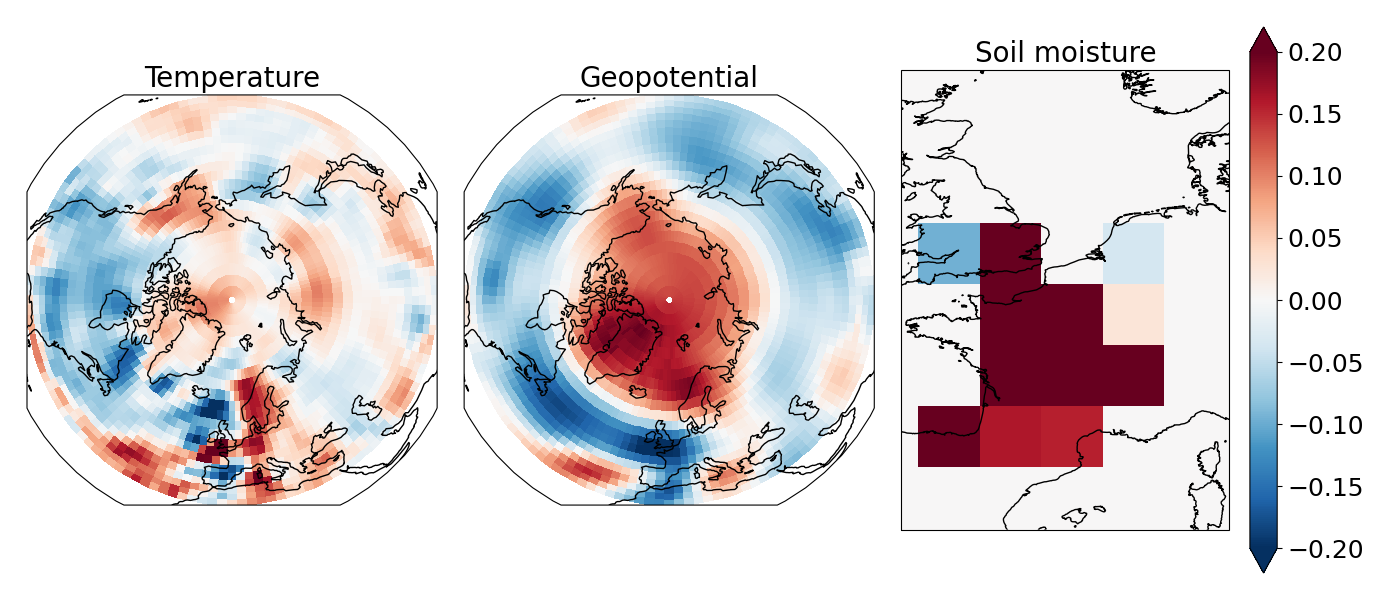

In [20]:
axs = cplt.mfp(LON,LAT, reshaper.inv_reshape(emp - ga), one_fig_layout=130,figsize=(14,6),mx = 0.2,fig_num=8+np.random.randint(0,50),titles=[r'Temperature', 'Geopotential', 'Soil moisture'],colorbar ='shared')
fig = axs[0].get_figure()
fig.savefig(f'{HOME}error_a_1.pdf')

## Table 3

In [ ]:
ds = xr.open_dataset('composite_maps_percent5_y8000.nc')
ds

In [ ]:
## area weights

coslat = np.cos(lat*np.pi/180)
aw = (np.ones(mask.shape).T * coslat).T
aw *= mask
aw /= np.sum(aw)
aw.shape

In [ ]:
T = [1,3,7,14,30]
taus = [0,3,6,9,12,15,18,21,24,27,30]

In [ ]:
emp = reshaper.inv_reshape(ds.empirical_composite.sel(T=T, tau=taus).data)
emp.shape

In [ ]:
norms_emp = l2(emp*np.sqrt(aw), axis =(2,3,4))
norms_emp.shape

In [ ]:
ga = reshaper.inv_reshape(ds.gaussian_composite.sel(T=T, tau= taus).data)
ga.shape

In [ ]:
diff_norm = l2((emp-ga)*np.sqrt(aw), axis =(2,3,4))
diff_norm.shape

In [ ]:
norm_ratio = np.round(diff_norm/norms_emp,2)

In [ ]:
xlabel = r'$\tau$ [days]'
ylabel = r'$T$ [days]'

_ = tbl.table(norm_ratio, taus, T, color_range=(0.2,0.9), xlabel=xlabel, ylabel=ylabel, title='Norm ratio', num=5, figsize=(7,3))

In [ ]:
_ = tbl.tex_table(norm_ratio, taus, T, color_range=(0.2,0.9), xlabel=xlabel, ylabel=ylabel, title='Norm ratio', close_left=False)
print(_)

## Table 2

In [ ]:
ds = xr.open_dataset('composite_maps_percent5_y8000.nc')
ds

In [ ]:
T = [1,3,7,14,30]
taus = [0,3,6,9,12,15,18,21,24,27,30]
sign = 2

In [ ]:
emp = ds.empirical_composite.sel(T=T, tau=taus).data
emp.shape

In [ ]:
ga = ds.gaussian_composite.sel(T=T, tau=taus).data
ga.shape

In [ ]:
std = ds.empirical_std_composite.sel(T=T, tau=taus).data
std.shape

In [ ]:
raw_significance = (emp-ga)/std

In [ ]:
## area weights

coslat = np.cos(lat*np.pi/180)
aw = (np.ones(mask.shape).T * coslat).T
aw *= mask
aw /= np.sum(aw)
aw.shape

In [ ]:
area_weights = reshaper.reshape(aw)

In [ ]:
sA = ((np.abs(raw_significance.T)*np.sqrt(ds.N_heatwave_years.data) > sign).T*area_weights).sum(axis=2)
sA.shape

In [ ]:
xlabel = r'$\tau$ [days]'
ylabel = r'$T$ [days]'

_ = tbl.table(sA, taus, T, color_range=(0.2,0.9), xlabel=xlabel, ylabel=ylabel, title=fr'Fraction of area with error above ${sign}\sigma$', num=5, figsize=(7,3))

In [ ]:
_ = tbl.tex_table(sA, taus, T, color_range=(0.2,0.9), xlabel=xlabel, ylabel=ylabel, title=fr'Fraction of area with error above ${sign}\sigma$', close_left=False)
print(_)

## Table S1, S2, S3

In [ ]:
ds = xr.open_dataset('composite_maps_percent5_y8000.nc')
ds

In [ ]:
## area weights

coslat = np.cos(lat*np.pi/180)
aw = (np.ones(mask.shape).T * coslat).T
aw *= mask
aw /= np.sum(aw)
aw.shape

field_axes = (-3,-2)

faw = aw / np.sum(aw, axis=field_axes) # fieldwise area weights

In [ ]:
T = [1,3,7,14,30]
taus = [0,3,6,9,12,15,18,21,24,27,30]

In [ ]:
emp = reshaper.inv_reshape(ds.empirical_composite.sel(T=T, tau=taus).data)
emp.shape

In [ ]:
ga = reshaper.inv_reshape(ds.gaussian_composite.sel(T=T, tau= taus).data)
ga.shape

In [ ]:
norms_emp = l2(emp*np.sqrt(faw), axis=field_axes)
norms_emp.shape

In [ ]:
norms_diff = l2((emp - ga)*np.sqrt(faw), axis=field_axes)
norms_diff.shape

In [ ]:
norm_ratio = norm_ratio = np.round(norms_diff/norms_emp,2)
norm_ratio.shape

In [ ]:
xlabel = r'$\tau$ [days]'
ylabel = r'$T$ [days]'
field_labels = ['Temperature', 'Geopotential', 'Soil moisture']

for i in range(3):
    _ = tbl.table(norm_ratio[...,i], taus, T, color_range=(0.2,0.9), xlabel=xlabel, ylabel=ylabel, title=f'{field_labels[i]}: Norm ratio', num=5+i, figsize=(7,3))

In [ ]:
for i in range(3):
    _ = tbl.tex_table(norm_ratio[...,i], taus, T, color_range=(0.2,0.9), xlabel=xlabel, ylabel=ylabel, title=f'{field_labels[i]}', close_left=False)
    print(_)

## Figure S3 

In [ ]:
density_plot = xr.open_dataset('density_plot.nc')
density_plot

In [ ]:
#Right plot
plt.close()
font = 55
fig = plt.figure(figsize=(18, 24))

gs = fig.add_gridspec(4, 2,width_ratios=(4, 1), height_ratios=(0.6,2.5,0.01,0.07),
                      left=0.12, right=0.92, bottom=0.03, top=0.99,
                      wspace=0.1, hspace=0.18)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])

ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

#Data
x=density_plot.Z_j.data
y=density_plot.A.data
bins=100

#Plots
h = ax.hist2d(x,y,bins=bins,density=True)

#colorbar
ax_color = fig.add_subplot(gs[3, 0])

cb = fig.colorbar(h[3], cax=ax_color, location='bottom',orientation='horizontal',extend='both')
cb.ax.tick_params(labelsize=50)

#lines
ax.axvline(np.interp(np.round(np.quantile(density_plot.A.data,0.95),2),density_plot.thresholds.data,density_plot.empirical_composite_Z.data), color='orange',linewidth=3, linestyle='dashed')
ax.axvline(np.interp(np.round(np.quantile(density_plot.A.data,0.95),2),density_plot.thresholds.data,density_plot.gaussian_composite_Z.data), color='white',linewidth=3, linestyle='dashed')

ax.plot(density_plot.empirical_composite_Z.data, density_plot.thresholds.data, color='orange', linewidth=3,label=r'$C_\mathcal{D}^j(a)$')
ax.plot(density_plot.gaussian_composite_Z.data, density_plot.thresholds.data, color='white', linewidth=3,label=r'$C_\mathcal{G}^j(a)$')

xis = np.linspace(np.min(x), np.max(x), 3)


ax.axhline(np.round(np.quantile(density_plot.A.data,0.95),2), color='red', linewidth=3,label=fr'$a={np.round(np.quantile(density_plot.A.data,0.95),2)} K$')
ax.set_xlabel('$Z^j$',fontsize=font)
# ax.set_ylabel('$A [K]$',fontsize=35)
ax.set_xlim(-2.2,2.2)
ax_histx.hist(x, bins=bins,density=True)
ax_histx.plot(np.sort(x), stats.norm.pdf(np.sort(x), x.mean(), x.std()),linewidth=3,color='black')
ax_histx.tick_params(axis="both",labelsize=font)
ax_histx.tick_params('x', labelbottom=False,labelsize=font)



ax_histy.hist(y, bins=bins,density=True, orientation='horizontal')
ax_histy.plot(stats.norm.pdf(np.sort(y), y.mean(), y.std()),np.sort(y),linewidth=3, color='black')
ax_histy.tick_params(axis="both",labelsize=font)
ax_histy.tick_params('y', labelleft=False)



ax.legend(fontsize="40",loc='upper right')

ax.tick_params(axis="both", labelsize=font)
# fig.savefig(f'{HOME}density_geop.pdf')

In [ ]:
#Left plot
fig = plt.figure(figsize=(18, 24))
font = 55
gs = fig.add_gridspec(4, 2,width_ratios=(4, 1), height_ratios=(0.6,2.5,0.01,0.07),
                      left=0.12, right=0.92, bottom=0.03, top=0.99,
                      wspace=0.1, hspace=0.18)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])

ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

#Data
x=density_plot.S_i.data
y=density_plot.A.data
bins=100

#Plots
h = ax.hist2d(x,y,bins=bins,density=True)

#colorbar
ax_color = fig.add_subplot(gs[3, 0])

cb = fig.colorbar(h[3], cax=ax_color, location='bottom',orientation='horizontal',extend='both')
cb.ax.tick_params(labelsize=50)

#lines
ax.axvline(np.interp(np.round(np.quantile(density_plot.A.data,0.95),2),density_plot.thresholds.data,density_plot.empirical_composite_S.data), color='orange',linewidth=3, linestyle='dashed')
ax.axvline(np.interp(np.round(np.quantile(density_plot.A.data,0.95),2),density_plot.thresholds.data,density_plot.gaussian_composite_S.data), color='white',linewidth=3, linestyle='dashed')

ax.plot(density_plot.empirical_composite_S.data, density_plot.thresholds.data, color='orange', linewidth=3,label=r'$C_\mathcal{D}^i(a)$')
ax.plot(density_plot.gaussian_composite_S.data, density_plot.thresholds.data, color='white', linewidth=3,label=r'$C_\mathcal{G}^i(a)$')

xis = np.linspace(np.min(x), np.max(x), 3)


ax.axhline(np.round(np.quantile(density_plot.A.data,0.95),2), color='red', linewidth=3,label=fr'$a={np.round(np.quantile(density_plot.A.data,0.95),2)} K$')
ax.set_xlabel('$S^i$',fontsize=font)
ax.set_ylabel('$A [K]$',fontsize=font)
ax.set_xlim(-2.2,2.2)
ax_histx.hist(x, bins=bins,density=True)
ax_histx.plot(np.sort(x), stats.norm.pdf(np.sort(x), x.mean(), x.std()),linewidth=3,color='black')
ax_histx.tick_params(axis="both",labelsize=font)
ax_histx.tick_params('x', labelbottom=False,labelsize=font)



ax_histy.hist(y, bins=bins,density=True, orientation='horizontal')
ax_histy.plot(stats.norm.pdf(np.sort(y), y.mean(), y.std()),np.sort(y),linewidth=3, color='black')
ax_histy.tick_params(axis="both",labelsize=font)
ax_histy.tick_params('y', labelleft=False)
fig.delaxes(ax_histy)



ax.legend(fontsize="40",loc='upper right')

ax.tick_params(axis="both", labelsize=font)

# fig.savefig(f'{HOME}density_soilmoist.pdf')